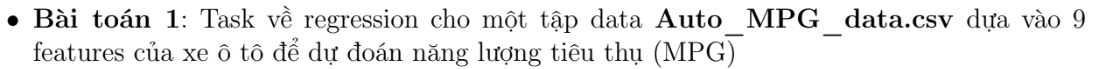

# Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [3]:
device

device(type='cuda', index=0)

# Datasets pre-processing

In [4]:
dataset_path = 'Auto_MPG_data.csv'
df = pd.read_csv(dataset_path)

df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [5]:
X = df.drop(columns='MPG').values
y = df['MPG'].values
X.shape, y.shape

((392, 9), (392,))

In [6]:
X[:5], y[:5]

(array([[8.000e+00, 3.070e+02, 1.300e+02, 3.504e+03, 1.200e+01, 7.000e+01,
         0.000e+00, 0.000e+00, 1.000e+00],
        [8.000e+00, 3.500e+02, 1.650e+02, 3.693e+03, 1.150e+01, 7.000e+01,
         0.000e+00, 0.000e+00, 1.000e+00],
        [8.000e+00, 3.180e+02, 1.500e+02, 3.436e+03, 1.100e+01, 7.000e+01,
         0.000e+00, 0.000e+00, 1.000e+00],
        [8.000e+00, 3.040e+02, 1.500e+02, 3.433e+03, 1.200e+01, 7.000e+01,
         0.000e+00, 0.000e+00, 1.000e+00],
        [8.000e+00, 3.020e+02, 1.400e+02, 3.449e+03, 1.050e+01, 7.000e+01,
         0.000e+00, 0.000e+00, 1.000e+00]]),
 array([18., 15., 18., 16., 17.]))

In [7]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [8]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 273
Number of val samples: 79
Number of test samples: 40


In [9]:
normalizer = StandardScaler ()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train , dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# Pytorch DataLoader

In [10]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False)

# Build MLP network

In [44]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [45]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims, hidden_dims, output_dims).to(device)

# Initiate loss function and optimizer

In [46]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# R2-score function

In [47]:
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    # convert tensor value to list
    return r2.tolist()

# Training

In [48]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

In [49]:
for epoch in range(epochs):
    train_batch_loss = []
    train_target = []
    train_predict = []
    
    val_target = []
    val_predict = []

    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        y_pred = model(X_samples)
        train_predict += y_pred.tolist()
        train_target += y_samples.tolist()
        # compute avg loss in a batch
        loss = criterion(y_pred, y_samples)
        loss.backward()
        optimizer.step()
        train_batch_loss.append(loss.item())
    
    epoch_train_loss = np.mean(train_batch_loss)
    train_losses.append(epoch_train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    
    val_batch_loss = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            y_pred = model(X_samples)
            val_predict += y_pred.tolist()
            val_target += y_samples.tolist()
            loss = criterion(y_pred, y_samples)
            val_batch_loss.append(loss.item())

    epoch_val_loss = np.mean(val_batch_loss)
    val_losses.append(epoch_val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    
    print(f'EPOCH {epoch+1}:\tTraining loss : {epoch_train_loss: .3f}\tValidation loss : {epoch_val_loss: .3f}')

EPOCH 1:	Training loss :  236.710	Validation loss :  159.122
EPOCH 2:	Training loss :  291.182	Validation loss :  30.834
EPOCH 3:	Training loss :  168.655	Validation loss :  160.675
EPOCH 4:	Training loss :  52.265	Validation loss :  6.912
EPOCH 5:	Training loss :  28.463	Validation loss :  4.549
EPOCH 6:	Training loss :  11.026	Validation loss :  8.407
EPOCH 7:	Training loss :  10.562	Validation loss :  9.780
EPOCH 8:	Training loss :  21.429	Validation loss :  18.564
EPOCH 9:	Training loss :  28.814	Validation loss :  15.742
EPOCH 10:	Training loss :  13.799	Validation loss :  7.134
EPOCH 11:	Training loss :  7.298	Validation loss :  4.767
EPOCH 12:	Training loss :  14.819	Validation loss :  15.214
EPOCH 13:	Training loss :  13.532	Validation loss :  6.881
EPOCH 14:	Training loss :  11.302	Validation loss :  5.413
EPOCH 15:	Training loss :  7.019	Validation loss :  5.449
EPOCH 16:	Training loss :  13.451	Validation loss :  47.060
EPOCH 17:	Training loss :  28.099	Validation loss :  8.

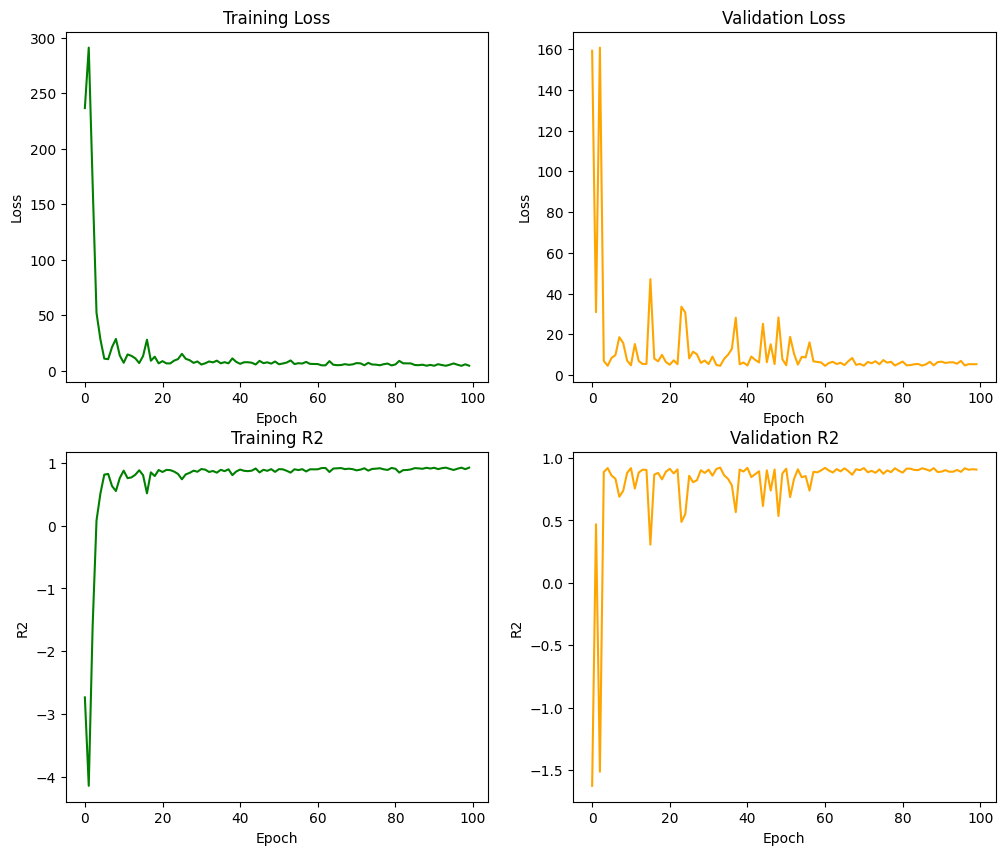

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_r2, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='R2')
ax[1, 0].set_title('Training R2')

ax[1, 1].plot(val_r2, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='R2')
ax[1, 1].set_title('Validation R2')

plt.show()

# Evaluation

In [52]:
model.eval()
with torch.no_grad():
    X_test = torch.Tensor(X_test).to(device)
    y_hat = model(X_test)
    test_set_r2 = r_squared(y_hat, y_test)
    print('Evaluation on test set:')
    print(f'R2: {test_set_r2}')

Evaluation on test set:
R2: 0.8748286962509155
